In [1]:
#General settings, imports and filepaths
import shap
import numpy as np
import geopandas as gpd
import pandas as pd
import dask_geopandas as dask_gpd
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
#filereads
filename = r'YourFilePathToReference'
ddf = dask_gpd.read_parquet(filename, npartitions=4)
df = ddf.compute()
print(f"Length of input is {len(ddf)}")

#Drop columns that include over 99% of Nulls that have little or no impact in classification (optional)
filter = (df.isnull().mean() * 100)>99
drop_me = filter[filter].index.to_list()
df = df.drop(columns=drop_me)

Length of input is 3962052


In [3]:
#create numerical classes from text classes
condlist = [df['MKV']=='1a', 
            df['MKV']=='1b',
            df['MKV']=='2a',
            df['MKV']=='2b',
            df['MKV']=='3a',
            df['MKV']=='3b',
            df['MKV']=='3c',
            df['MKV']=='4a',
            df['MKV']=='4b',
            df['MKV']=='4c',
            df['MKV']=='4d']
choicelist = [0,1,2,3,4,5,6,7,8,9,10]
df['MKV_class'] = np.select(condlist, choicelist)

In [4]:
#Define columns to use
Pos_columns = ['Kasvupaikka','Ika_MaxYhdistetty_Mean', 'KKorkeus8m_Mean', 'KokTilavuusUusi_Mean', 'MZonationValt2_Mean','All90PercEtela4KL_BTKUVuusiA_Peitto','MantyVol_Osuus','LehtipVol_Osuus','MantyVol_Mean','LehtipVol_Mean']
Bonus_columns = ['Pohjantikka_Mean','Kanahaukka_Mean','Valkoselkatikka_Mean']
Neg_columns = ['MKI_Perc', 'GFW_Perc', 'Ojitus_Perc','Ihmispaine16m_Mean','Kiinteisto1_5haRakennusPerc','Rakennukset30mPerc']
Maybe_columns = ['KKL2m_Median', 'KKL2m_Mean', 'KKL2m_Std','Ika_MaxYhdistetty_Std']
Other_columns = ['MKV_class','Rakenne_Mean','Rakenne_Std', 'KKL2m_Area']
All_columns = Pos_columns + Bonus_columns + Neg_columns + Maybe_columns + Other_columns
print(f"number of variables used in the equation is: {len(All_columns)}")
print(All_columns)


#Classifiers dont work with empty values.
#Either fill nans with zeroes, imputer or other more complex method
#Fill NaNs with zeroes OR...
df[All_columns] = df[All_columns].fillna(0)

number of variables used in the equation is: 27
['Kasvupaikka', 'Ika_MaxYhdistetty_Mean', 'KKorkeus8m_Mean', 'KokTilavuusUusi_Mean', 'MZonationValt2_Mean', 'All90PercEtela4KL_BTKUVuusiA_Peitto', 'MantyVol_Osuus', 'LehtipVol_Osuus', 'MantyVol_Mean', 'LehtipVol_Mean', 'Pohjantikka_Mean', 'Kanahaukka_Mean', 'Valkoselkatikka_Mean', 'MKI_Perc', 'GFW_Perc', 'Ojitus_Perc', 'Ihmispaine16m_Mean', 'Kiinteisto1_5haRakennusPerc', 'Rakennukset30mPerc', 'KKL2m_Median', 'KKL2m_Mean', 'KKL2m_Std', 'Ika_MaxYhdistetty_Std', 'MKV_class', 'Rakenne_Mean', 'Rakenne_Std', 'KKL2m_Area']


In [5]:
#Create the dependent variable y to classify in. based on reference overlap
condition1 = df['AllReferencePolygons_pc']>50 #overlap with reference over x%
all_conditions_met = condition1 
df['OGF'] = all_conditions_met.astype(int) # Convert the boolean array to 0s and 1s using astype(int)

# Random forest

In [7]:
#pre process data
def normalize_column(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(x - min_val) / (max_val - min_val) for x in column]
    return normalized_column
    

X = df[All_columns]
normalized_x = []
for column in X:
    #variable names
    name = column + '_norm'
    name2 = column + '_imputed'
    name3 = column + '_z'
    #print(name)
    normalized_x.append(name)

    #if nodatavalue 999, then assign as median
    df[column]=df[column].replace(999, df[column].quantile(0.5))

    #missing data filling. nulls are already filled with zeroes on line 42, so here no impact, comment it out for this to take effect
    imputer = SimpleImputer(strategy='median')  # or 'mean', median', 'most_frequent', 'constant'.
    df[name2] = imputer.fit_transform(df[[column]])

    #outlier detection with z-score and their removal
    df[name3] = stats.zscore(df[name2])
    outlier_threshold = 3
    outliers = (df[name3] > outlier_threshold) #|(df[name3] < -outlier_threshold) if lower outliers need to be processed
    np.where(outliers, max(column),column) #if outlier, replace with max value

    #normalization function
    df[name] = normalize_column(df[name3])

print(f"columns used and normalized: {normalized_x}")

columns used and normalized: ['Kasvupaikka_norm', 'Ika_MaxYhdistetty_Mean_norm', 'KKorkeus8m_Mean_norm', 'KokTilavuusUusi_Mean_norm', 'MZonationValt2_Mean_norm', 'All90PercEtela4KL_BTKUVuusiA_Peitto_norm', 'MantyVol_Osuus_norm', 'LehtipVol_Osuus_norm', 'MantyVol_Mean_norm', 'LehtipVol_Mean_norm', 'Pohjantikka_Mean_norm', 'Kanahaukka_Mean_norm', 'Valkoselkatikka_Mean_norm', 'MKI_Perc_norm', 'GFW_Perc_norm', 'Ojitus_Perc_norm', 'Ihmispaine16m_Mean_norm', 'Kiinteisto1_5haRakennusPerc_norm', 'Rakennukset30mPerc_norm', 'KKL2m_Median_norm', 'KKL2m_Mean_norm', 'KKL2m_Std_norm', 'Ika_MaxYhdistetty_Std_norm', 'MKV_class_norm', 'Rakenne_Mean_norm', 'Rakenne_Std_norm', 'KKL2m_Area_norm']


In [8]:
#define target variable Y or dependent variable as x is independent -> y = x1 + x2 -x3 equation
Y = df['OGF']
#define independent variables
X = df[normalized_x]
#split data into train and test sections
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
classifier = RandomForestClassifier(n_estimators=20,criterion='gini', random_state= 0, n_jobs=-1) #gini, entropy
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_pred_perc = classifier.predict_proba(X_test)[:,1] #[:,0]is probability of class 0, [:,1] of class 1

# Shap

In [15]:
#do some sampling to overcome computational requirements of handling the whole dataset
#keep in mind that if the OGF=1 is only minority, subset might include only one or less such cases and draw conclusions
#sampling techniques should be considered. using all is computationally expensive if 1000 takes 5min on i9 cpu, 4000 took 153m
condition0 = df.OGF == 0
condition1 = df.OGF == 1
OGF0 = df[condition0]
OGF1 = df[condition1]
#sample 2k points from both y-classes
OGF0_1000 = OGF0.sample(n=2000) #optionally set random state to 42 for reproducibility
OGF1_1000 = OGF1.sample(n=2000)  
#combine this to one sample set
sample = pd.concat([OGF0_1000,OGF1_1000])

#or for random sampling
#X1000 = shap.utils.sample(X, 1000)

In [17]:
#the computationally expensive calculation on shap values
explainer = shap.Explainer(classifier)
shap_values = explainer(sample[All_columns])

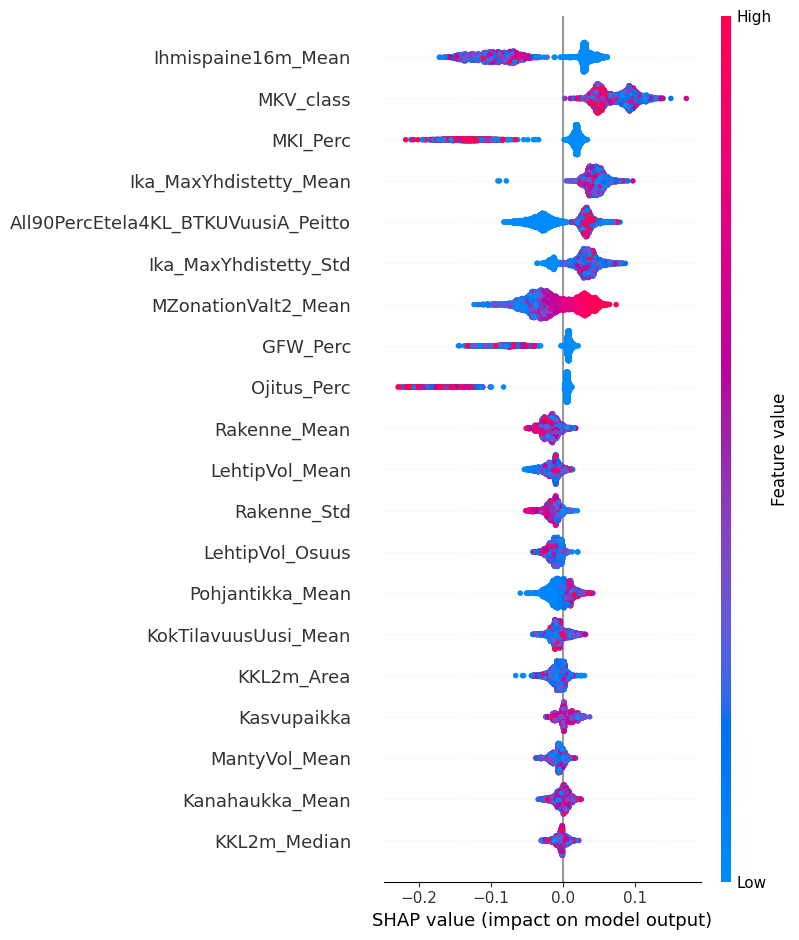

In [23]:
class_idx = 1  # index of the class you're interested in, here it is OGF = 1
shap.summary_plot(shap_values[:, :, class_idx], sample[All_columns])

Sure, I'd be happy to explain the SHAP summary plot.

The SHAP summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance¹. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high¹.

Here's a more detailed explanation:

- **Y-axis (Features)**: Each row in the summary plot corresponds to a feature in your dataset. The features are ordered by their importance, which is calculated as the sum of the absolute Shapley values for each feature¹.

- **X-axis (SHAP Values)**: The x-axis shows the SHAP values, which represent the impact of each feature on the model's output. Features pushing the prediction higher are shown in red, and those pushing the prediction lower are in blue¹.

- **Color (Feature Value)**: The color of each dot represents the actual value of the feature. High values are shown in red, and low values are in blue¹.

- **Width (Density)**: The width of the 'cloud' of points for each feature represents the density of the data. A wider section indicates that more data points have a given SHAP value¹.

The SHAP summary plot provides a holistic view of the feature importance and effects. It allows you to see which features are most important for a model's output across a dataset and how the values of those features impact the predictions¹.

I hope this helps! If you have any more questions, feel free to ask.

Source: Conversation with Bing, 12/11/2023
(1) 9.6 SHAP (SHapley Additive exPlanations) | Interpretable Machine Learning. https://christophm.github.io/interpretable-ml-book/shap.html.
(2) SHAP: How to Interpret Machine Learning Models With Python. https://betterdatascience.com/shap/.
(3) An Introduction to SHAP Values and Machine Learning ... - DataCamp. https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability.
(4) undefined. https://github.com/slundberg/sha_p%29_%29.

# Additional explanations of shapley values and waterfall plot
Not necessary to calculate or run

The two plots are to see the function on a binary classifier. Use .shape() to see the output shape and notice that in binary cases there are 2 classes, with one being the same value as the other, just negative (e.g. 2 and -2), because of this, using only the other value is necessary. class_idx is to change this

Each waterfall plot is for one single feature, whereas in summary plot each dot is one "waterfall plot"

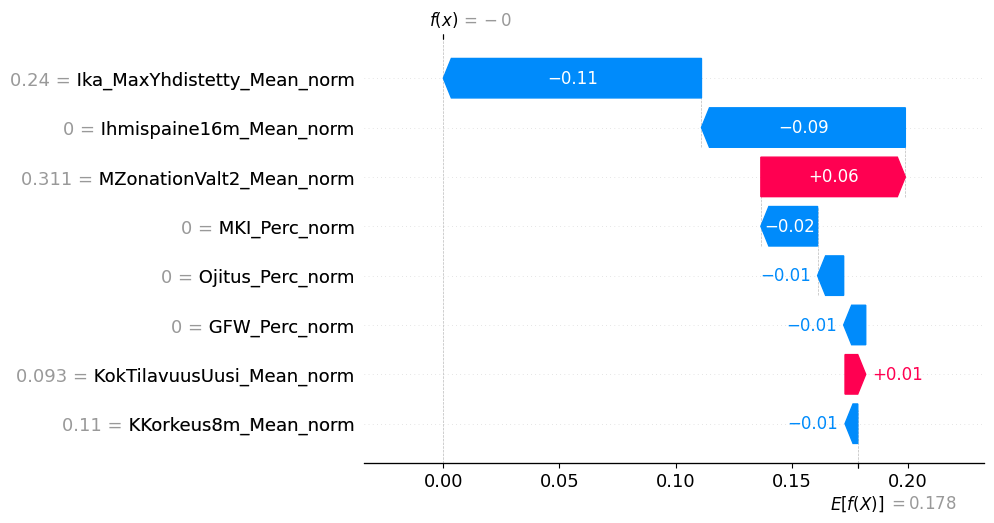

In [56]:
# Select the SHAP values for the first class of the first instance. waterfall plot only for one feature at a time
#random 1000
instance_idx = 1
class_idx = 0 #compare with the one below. in binary class both can be used. values reman the same, just opposite
shap.waterfall_plot(shap_values[instance_idx, :, class_idx])

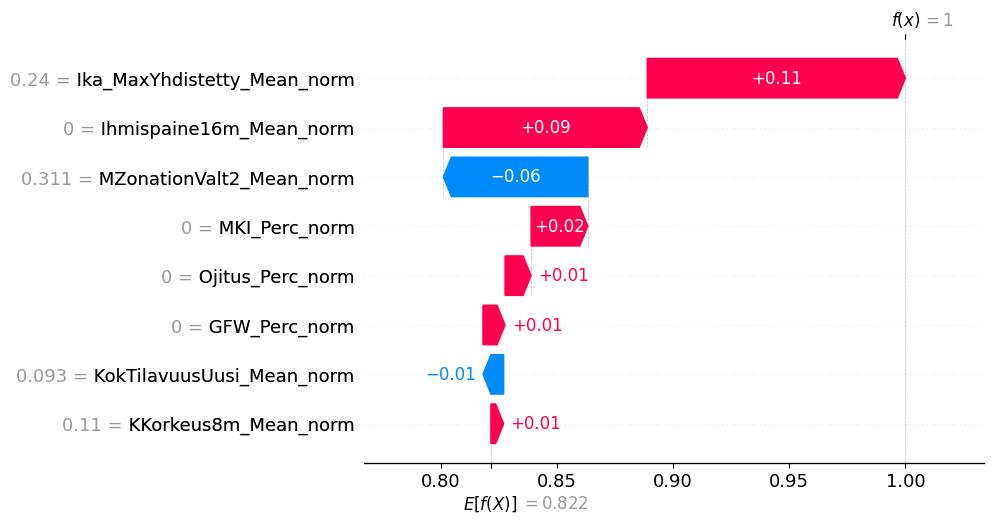

In [52]:
# Select the SHAP values for the first class of the first instance
#random 1000
instance_idx = 1
class_idx = 1
shap.waterfall_plot(shap_values[instance_idx, :, class_idx])

Efx=average predicted OGF
fx=predicted OGF for feature instance_idx = 0
shap value, how much spesific variable has contributed to total outcome
when average 0.178 and age +0.09, it is a pos impact
values on the left are averages

https://www.youtube.com/watch?v=L8_sVRhBDLU
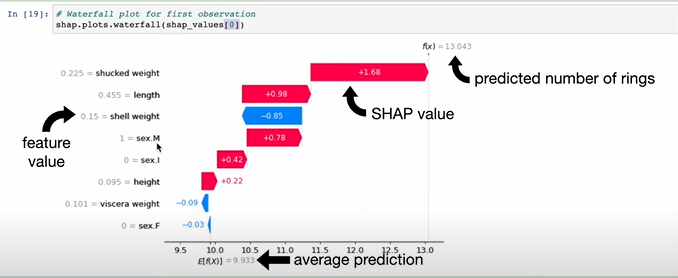